In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

## Paramètres du modèle

In [3]:
r = 0.02  # Taux sans risque
S0 = 100  # Prix initial de l'actif sous-jacent
kappa = 0.12  # Drift
sigma = 0.2  # Volatilité
hl = 0.25  # 3 mois en années
T = 5  # Maturité
delta = 1/52 # one week in years
gamma = 0.01 # exponential default times 100 bps 

In [4]:
def black_scholes_paths(S0, r, sigma, T, dt, N_paths):
    """Génère des trajectoires de Black-Scholes par Euler-Maruyama"""
    N_steps = int(T / dt)
    S = np.zeros((N_steps + 1, N_paths))
    S[0] = S0
    for t in range(1, N_steps + 1):
        Z = np.random.normal(0, 1, N_paths)
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return S

## Simulation Monte Carlo

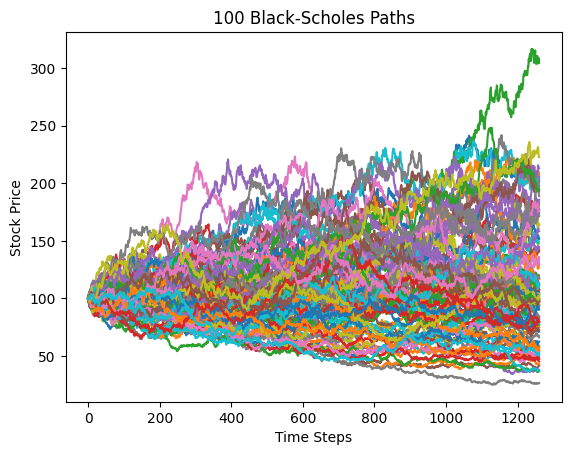

In [6]:
# Plot 100 paths
N_paths = 100
T = 5
dt = 1/252

paths = black_scholes_paths(S0, r, sigma, T, dt, N_paths)
plt.plot(paths)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('100 Black-Scholes Paths')
plt.show()

## Mark-to-Market computation

In [ ]:
N_paths = 5000
dt = 1/252  # Pas journalier
S_paths = black_scholes_paths(S0, r, sigma, T, dt, N_paths)
t_grid = np.linspace(0, T, int(T / hl) + 1)

# 3. Calcul du processus MtM

def MtM(t, S_bar=S0):
    step = 1/dt
    beta_t = np.exp(r * (T - t))
    betas = np.exp(- r * (T - t_grid) )
    # The nominal (Nom) of the swap is set so that each leg has a time-0 mark-to-market of 1
    Nom = np.exp(-r * T) / (sum( [ betas[l] * ( np.exp(kappa * t_grid[l-1]) * S_paths[0] - S_bar) for l in range( 1 , len(t_grid)) ] ) * hl)
        # print(f'Nominal: {Nom[0]}')
    # l_t is the index of t_grid such that t_grid[l_t - 1] <= t < t_grid[l_t]
    l_t = min( np.argmin(np.abs(t_grid - t)) +  1, 20)
        # print(f'l_t: {l_t}')
    S_t = S_paths[int(t * step)] # S_t = S(t)
    S_hat = np.exp(-kappa * t) * S_t 

    Σ = sum( [ betas[l] * ( np.exp(kappa * t_grid[l-1]) * S_hat - S_bar) for l in range(l_t + 1, len(t_grid)) ] )

    MtM = Nom * beta_t * hl * ( betas[l_t] * (S_paths[int(t_grid[l_t - 1] * step)] - S_bar) + Σ)
    
    return MtM


In [ ]:
MtMs = [MtM(t) for t in np.linspace(0, T, int(T / dt) + 1)]

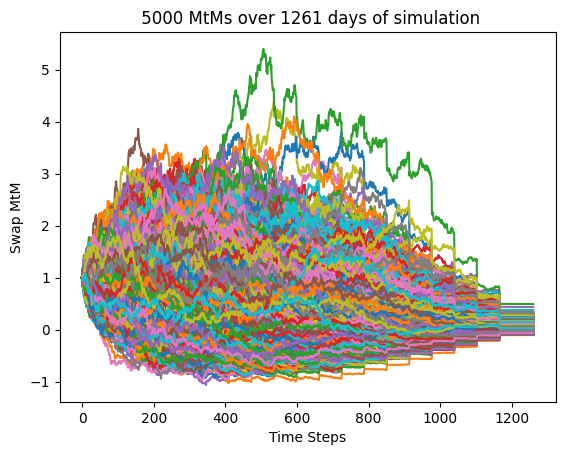

In [19]:
# Plot MtMs

plt.plot(MtMs)
plt.xlabel('Time Steps')
plt.ylabel('Swap MtM')
plt.title(f' {len(MtMs[0])} MtMs over {len(MtMs)} days of simulation')
plt.show()